# 基于LDA 的简历匹配【将简历归到不同的招聘类目下】

In [1]:
from pprint import pprint
import pandas as pd
import re

In [2]:
import spacy
nlp = spacy.load('en')

In [3]:
stoplist = ['very', 'ourselves', 'am', 'doesn', 'through', 'me', 'against', 'up', 'just', 'her', 'ours', 
            'couldn', 'because', 'is', 'isn', 'it', 'only', 'in', 'such', 'too', 'mustn', 'under', 'their', 
            'if', 'to', 'my', 'himself', 'after', 'why', 'while', 'can', 'each', 'itself', 'his', 'all', 'once', 
            'herself', 'more', 'our', 'they', 'hasn', 'on', 'ma', 'them', 'its', 'where', 'did', 'll', 'you', 
            'didn', 'nor', 'as', 'now', 'before', 'those', 'yours', 'from', 'who', 'was', 'm', 'been', 'will', 
            'into', 'same', 'how', 'some', 'of', 'out', 'with', 's', 'being', 't', 'mightn', 'she', 'again', 'be', 
            'by', 'shan', 'have', 'yourselves', 'needn', 'and', 'are', 'o', 'these', 'further', 'most', 'yourself', 
            'having', 'aren', 'here', 'he', 'were', 'but', 'this', 'myself', 'own', 'we', 'so', 'i', 'does', 'both', 
            'when', 'between', 'd', 'had', 'the', 'y', 'has', 'down', 'off', 'than', 'haven', 'whom', 'wouldn', 
            'should', 've', 'over', 'themselves', 'few', 'then', 'hadn', 'what', 'until', 'won', 'no', 'about', 
            'any', 'that', 'for', 'shouldn', 'don', 'do', 'there', 'doing', 'an', 'or', 'ain', 'hers', 'wasn', 
            'weren', 'above', 'a', 'at', 'your', 'theirs', 'below', 'other', 'not', 're', 'him', 'during', 'which']

In [4]:
# 文本清洗，
def clean_email_text(text):
    text = text.replace('\n'," ") 
    text = re.sub(r"-", " ", text) 
    text = re.sub(r"\d+/\d+/\d+", "", text) 
    text = re.sub(r"[0-2]?[0-9]:[0-6][0-9]", "", text) 
    text = re.sub(r"[\w]+@[\.\w]+", "", text)
    text = re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text) 
    pure_text = ''
    
    for letter in text:
        # 只留下字母和空格
        if letter.isalpha() or letter==' ':
            pure_text += letter

    text = ' '.join(word for word in pure_text.split() if len(word)>1)
    return text

## 转为小写，去除停用词
def text_split_remove_stopwords(string):
    return [word for word in string.lower().split() if word not in stoplist]

## 词语转词根
def word_to_lemma(text):
    return [word.lemma_ for word in nlp(' '.join(text))]

# total_list = [[word.lemma_ for word in nlp(' '.join(text))] for text in texts]    

### 导入招聘信息

In [5]:
df = pd.read_csv(r'E:\dataset\data job posts.csv',usecols = ['Title','JobRequirment'])
df = df.dropna()
df

,Title,JobRequirment
0,Chief Financial Officer,- Supervises financial management and administ...
2,Country Coordinator,- Working with the Country Director to provide...
3,BCC Specialist,- Identify gaps in knowledge and overseeing in...
4,Software Developer,- Rendering technical assistance to Database M...
8,Assistant to Managing Director,- Coordinating the work of subordinate employe...
...,...,...
18996,Senior Creative UX/ UI Designer,- Work closely with product and business teams...
18997,Category Development Manager,- Establish and manage Category Management dev...
18998,Operational Marketing Manager,"- Develop, establish and maintain marketing st..."
18999,Head of Online Sales Department,- Handle the project activites of the online s...


### 文本清洗

In [6]:
df['JobRequirment'] = df['JobRequirment'].apply( clean_email_text )
df['JobRequirment'] = df['JobRequirment'].apply( text_split_remove_stopwords )
df['JobRequirment'] = df['JobRequirment'].apply( word_to_lemma )
df

,Title,JobRequirment
0,Chief Financial Officer,"[supervise, financial, management, administrat..."
2,Country Coordinator,"[work, country, director, provide, environment..."
3,BCC Specialist,"[identify, gaps, knowledge, oversee, informati..."
4,Software Developer,"[render, technical, assistance, database, mana..."
8,Assistant to Managing Director,"[coordinate, work, subordinate, employee, main..."
...,...,...
18996,Senior Creative UX/ UI Designer,"[work, closely, product, business, team, ident..."
18997,Category Development Manager,"[establish, manage, category, management, deve..."
18998,Operational Marketing Manager,"[develop, establish, maintain, marketing, stra..."
18999,Head of Online Sales Department,"[handle, project, activite, online, store, sta..."


# 基于 LDA 的招聘信息分类

In [8]:
from gensim import corpora, models
import gensim
from gensim.test.utils import datapath
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [9]:
doclist = list( df['JobRequirment'] )
dictionary = corpora.Dictionary(doclist)
corpus = [dictionary.doc2bow(text) for text in doclist]

### 使用 LDA 进行建模， 分为7类

In [58]:
topic_number = 7
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics = topic_number )

### 打印不同主题下的 关键词权重

In [59]:
lda.print_topics( num_topics = topic_number, num_words=10 )

[(0,
  '0.013*"training" + 0.011*"organize" + 0.010*"staff" + 0.009*"provide" + 0.009*"employee" + 0.008*"information" + 0.008*"office" + 0.007*"meeting" + 0.007*"conduct" + 0.007*"include"'),
 (1,
  '0.021*"system" + 0.017*"responsible" + 0.012*"company" + 0.012*"ensure" + 0.012*"sale" + 0.011*"network" + 0.010*"equipment" + 0.010*"work" + 0.010*"support" + 0.009*"manage"'),
 (2,
  '0.018*"ensure" + 0.014*"plan" + 0.012*"provide" + 0.011*"business" + 0.011*"team" + 0.011*"activity" + 0.010*"project" + 0.008*"management" + 0.008*"development" + 0.008*"support"'),
 (3,
  '0.020*"report" + 0.019*"prepare" + 0.018*"financial" + 0.013*"ensure" + 0.012*"bank" + 0.010*"account" + 0.010*"control" + 0.010*"provide" + 0.010*"document" + 0.010*"responsible"'),
 (4,
  '0.022*"design" + 0.017*"software" + 0.017*"work" + 0.017*"develop" + 0.017*"team" + 0.016*"test" + 0.014*"application" + 0.013*"development" + 0.012*"technical" + 0.012*"provide"'),
 (5,
  '0.033*"project" + 0.015*"ensure" + 0.013*

### 绘制各个主题分类的词云

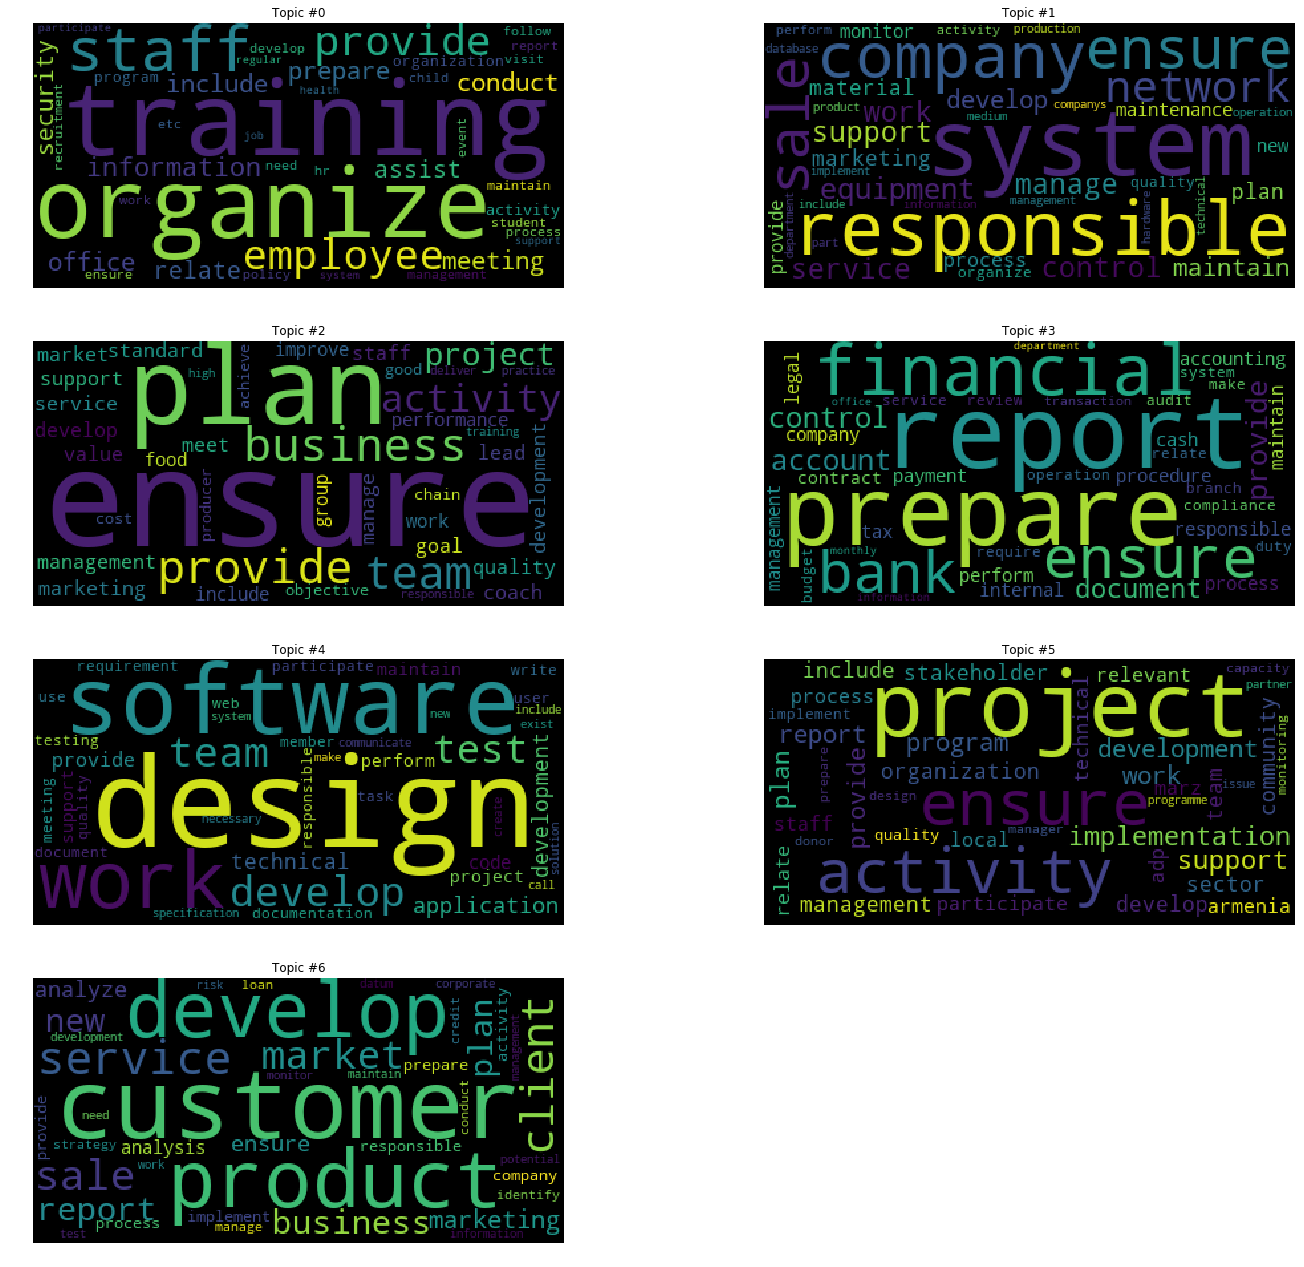

In [61]:
index = 0
fig = plt.figure(figsize=(24, 40))

for t in range(lda.num_topics):
    index += 1
    plt.subplot( int(topic_number+1/2) , 2, index )
    
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t, 40))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
#     plt.show()

# 判断不同简历属于哪个主题

### 读入简历数据

In [69]:
def resume_clean( test_string ):
    test_string = clean_email_text( test_string )
    test_string = text_split_remove_stopwords( test_string )
    test_string = word_to_lemma( test_string )
    
    return test_string

In [70]:
resume_df = pd.read_csv(r'E:\dataset\resume_dataset.csv' ,usecols = ['Resume'] )
resume_df

,Resume
0,"b'John H. Smith, P.H.R.\n800-991-5187 | PO Box..."
1,b'Name Surname\nAddress\nMobile No/Email\nPERS...
2,b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...
3,b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nC...
4,"b""HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert..."
...,...
1214,"b""Free Flight Attendant Resume\nDarlene Flint\..."
1215,b'Corporate Flight Attendant Resume\nCAITLIN F...
1216,"b'MAJOR CONRAD A. PREEDOM\n2354 Fairchild Dr.,..."
1217,b'STACY SAMPLE\n\n702 800-0000 cell\n\n0000@em...


随机取一条简历

In [78]:
test_string = resume_df.sample(1).iloc[0]['Resume']
print(eval(test_string[1:]))

David Shapiro
resume@david-shapiro.net
http://www.linkedin.com/in/dgshapiro
Web Developer Resume & Portfolio
Summary

Fifteen years professional Internet industry experience in web development, database design, integration,
implementation, software development, network and systems administration, and training.

Skills
Expert / Advanced
Cake PHP, Drupal CMS, JQuery, Javascript, MySQL, Java, Struts 2, CSS 3, DOM 0-3, AJAX / DHTML,
Dreamweaver, Aptana IDE, Netbeans IDE, Firebug
Competent
Object Oriented PHP, J2EE, JPA, Struts 1, Webwork, Spring, Hibernate, Tomcat, Apache, SSL, JSP, Dojo, A12Y,
I18N, Eclipse IDE, Photoshop, Acrobat, Zend Server, Linux / Unix, Windows
Moderate Exposure
Web Services (WSDL/REST/SOAP), Ant, JSF, JBOSS, SEAM, Glassfish, EJB 3.0, Tiles, UML, JMS, LDAP,
Velocity, Perl, Postgress, Subversion, Oracle Toplink, Oracle SQL
Clients & Project Portfolio
Boys & Girls Club Web Development Consultant 2006 - present

o
o
o

End to end web development
Cake PHP, MySQL, jQuery,

判断其属于哪个主题类别，并输出概率

In [79]:
id2word = lda.id2word 
doc_bow = id2word.doc2bow( test_string.split() )
t = lda.get_document_topics(doc_bow)
print( t )

label, prob = sorted(t, key=lambda x: -x[1])[0]
print( '该简历属于',label,'类别' ,'的概率最大:', prob )
lda.print_topic( label )

[(0, 0.014345355), (1, 0.11727262), (2, 0.06272683), (3, 0.05651182), (4, 0.5652477), (5, 0.13018745), (6, 0.053708196)]
该简历属于 4 类别 的概率最大: 0.5652477


'0.022*"design" + 0.017*"software" + 0.017*"work" + 0.017*"develop" + 0.017*"team" + 0.016*"test" + 0.014*"application" + 0.013*"development" + 0.012*"technical" + 0.012*"provide"'